# 공공데이터 활용 수력 댐 강우예측 AI 경진대회
## Public 3rd, Private 1st / 132 (Winner)

- Competiton link : https://dacon.io/competitions/official/235646/overview/description
- Data : https://dacon.io/competitions/official/235646/data/

# 0. Environment

- OS : Windows10
- CPU : AMD Ryzen5 3500X
- RAM : 32GB
- SSD : 512GB + 128GB
- GPU : RTX 2060 Super (8GB)
- CUDA : 10.1
- Driver : 432.00

In [1]:
#├── Final Code.ipynb  (실행파일)  
#├── data  
#│      ├── test  
#│      │     ├── test_00000.npy  
#│      │     ├── test_00001.npy
#│      │     ├──      ...  
#│      │     └── test_02673.npy  
#│      ├── train  
#│      │       └── train  
#│      │                ├── train_00000.npy  
#│      │                ├── train_00001.npy  
#│      │                ├──      ...  
#│      │                └── train_62734.npy  
#│      └── sample_submission.csv  
#│
#│
#├── 10 Model Files (Try10_1_Model_{i}.h5      

# 1. Load Data

In [2]:
data_dir = './data/'
train_dir = data_dir + 'train/train/'
test_dir = data_dir + 'test/'

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split, KFold
import time

In [3]:
version = !python --version
print(f"Python Version : {version[0]}")
print(f"pandas Version : {pd.__version__}")
print(f"numpy Version : {np.__version__}")
print(f"Seaborn Version : {sns.__version__}")
import sklearn
print(f"Sklearn Version : {sklearn.__version__}")

Python Version : Python 3.7.8
pandas Version : 1.1.3
numpy Version : 1.18.5
Seaborn Version : 0.11.0
Sklearn Version : 0.23.2


In [4]:
def load_data(directory):
    filename_list = os.listdir(directory)
    filename_list.sort()
    
    data = []
    
    for file in tqdm(filename_list):
        d = np.load(directory + file) / 255
        data.append(d.astype('float32'))
    data = np.array(data)
    return data

In [5]:
train = load_data(train_dir)

Xtrain = train[:,:,:,:-1]
Ytrain = np.expand_dims(train[:,:,:, -1], axis=-1)
print(Xtrain.shape, Ytrain.shape)

del train

100%|███████████████████████████████████████████████████████████████████████████| 62735/62735 [05:52<00:00, 177.80it/s]


(62735, 120, 120, 4) (62735, 120, 120, 1)


In [6]:
Xtest = load_data(test_dir)
submission = pd.read_csv(data_dir + '/sample_submission.csv', index_col='file_name')

100%|█████████████████████████████████████████████████████████████████████████████| 2674/2674 [00:19<00:00, 138.80it/s]


<AxesSubplot:>

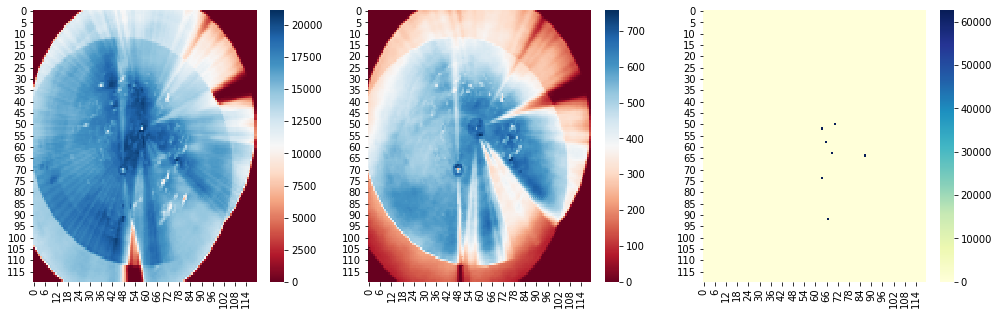

In [7]:
alpha = np.zeros(shape=(len(Ytrain), 14400))
alpha[:,[6071, 6304, 7026, 7629, 7767, 8944, 11107]]= 1
alpha = alpha.reshape(-1, 120, 120).sum(axis=0)

figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(17, 5)
sns.heatmap(Xtrain.sum(axis=-1).sum(axis=0), ax=ax1, cmap='RdBu')
sns.heatmap(Xtest.sum(axis=-1).sum(axis=0), ax=ax2, cmap='RdBu')
sns.heatmap(alpha, ax=ax3, cmap='YlGnBu')

# 2. Build Model

In [8]:
import keras 
import keras.backend as K

from keras.layers import *
from keras.models import Model
from keras.losses import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Nadam
from keras.metrics import AUC

print(f"Keras Version : {keras.__version__}")

def mae255(y_true, y_pred):
    return 255 * mean_absolute_error(y_true, y_pred)

Keras Version : 2.4.3


## UNET Based Model with ConvLSTM Skip Connection

In [17]:
def build_fn(input_shape = (120, 120, 4), filter_size=64, activation='elu', lr = 0.0003, init='he_normal', dropout_rate=0.25, 
             lstm_size=16):
    
    model_in = Input(shape=input_shape)
    x1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(model_in)
    res = BatchNormalization()(x1)
    #res = x1
    x1 = Activation(activation)(res)
    x1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation(activation)(x1)
    x1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Add()([x1, res])
    x1_res = Activation(activation)(x1)
    #x1_res = x1
    x1 = MaxPooling2D()(x1_res)
    
    
    
    x2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x1)
    res = BatchNormalization()(x2)
    #res = x2
    x2 = Activation(activation)(res)
    x2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation(activation)(x2)
    x2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Add()([x2, res])
    x2_res = Activation(activation)(x2)
    #x2_res = x2
    x2 = MaxPooling2D()(x2_res)
    
    
    
    x3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x2)
    x3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x3)
    x3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x3)
    res = BatchNormalization()(x3)
    #res = x3
    x3 = Activation(activation)(res)
    x3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x3)
    x3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x3)
    x3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation(activation)(x3)
    x3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x3)
    x3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x3)
    x3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x3)
    x3 = BatchNormalization()(x3)
    x3 = Add()([x3, res])
    x3_res = Activation(activation)(x3)
    #x3_res = x3
    x3 = MaxPooling2D()(x3_res)
    if dropout_rate != 0:
        x3 = SpatialDropout2D(dropout_rate)(x3)
        
    x = Convolution2D(filter_size*8/4, 1, padding='same', kernel_initializer=init)(x3)
    x = Convolution2D(filter_size*8/4, 3, padding='same', kernel_initializer=init)(x)
    x = Convolution2D(filter_size*8, 1, padding='same', kernel_initializer=init)(x)
    res = BatchNormalization()(x)
    #x_res = x
    x = Activation(activation)(res)
    x = Convolution2D(filter_size*8/4, 1, padding='same', kernel_initializer=init)(x)
    x = Convolution2D(filter_size*8/4, 3, padding='same', kernel_initializer=init)(x)
    x = Convolution2D(filter_size*8, 1, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Convolution2D(filter_size*8/4, 1, padding='same', kernel_initializer=init)(x3) #Mis
    x = Convolution2D(filter_size*8/4, 3, padding='same', kernel_initializer=init)(x)
    x = Convolution2D(filter_size*8, 1, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Add()([x, res])
    x = Activation(activation)(x)
    if dropout_rate != 0:
        x = SpatialDropout2D(dropout_rate)(x)
    
    
    
    x_3 = Conv2DTranspose(filter_size*4, 3, padding='same', strides=2)(x)
    x_3 = Concatenate(axis=-1)([x_3, x3_res])
    
    x_3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x_3)
    res = BatchNormalization()(x_3)
    #res = x_3
    x_3 = Activation(activation)(res)
    x_3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x_3)
    x_3 = BatchNormalization()(x_3)
    x_3 = Activation(activation)(x_3)
    x_3 = Convolution2D(filter_size*4/4, 1, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4/4, 3, padding='same', kernel_initializer=init)(x_3)
    x_3 = Convolution2D(filter_size*4, 1, padding='same', kernel_initializer=init)(x_3)
    x_3 = BatchNormalization()(x_3)
    x_3 = Add()([x_3, res])
    x_3 = Activation(activation)(x_3)
    
    
    
    x_2 = Conv2DTranspose(filter_size*2, 3, padding='same', strides=2)(x_3)
    x_2 = Concatenate(axis=-1)([x_2, x2_res])
    
    x_2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x_2)
    res = BatchNormalization()(x_2)
    #res = x_2
    x_2 = Activation(activation)(x_2)
    x_2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation)(x_2)
    x_2 = Convolution2D(filter_size*2, 3, padding='same', kernel_initializer=init)(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Add()([x_2, res])
    x_2 = Activation(activation)(x_2)
    
    
    
    x_1 = Conv2DTranspose(filter_size, 3, padding='same', strides=2)(x_2)
    x_1 = Concatenate(axis=-1)([x_1, x1_res])
    
    x_1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(x_1)
    res = BatchNormalization()(x_1)
    #res = x_1
    x_1 = Activation(activation)(x_1)
    x_1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation)(x_1)
    x_1 = Convolution2D(filter_size, 3, padding='same', kernel_initializer=init)(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Add()([x_1, res])
    x_u = Activation(activation)(x_1)
    
    
    in1 = model_in[:,:,:,0]
    in2 = model_in[:,:,:,1]
    in3 = model_in[:,:,:,2]
    in4 = model_in[:,:,:,3]
    in1 = Reshape((1, 120, 120, 1))(in1)
    in2 = Reshape((1, 120, 120, 1))(in2)
    in3 = Reshape((1, 120, 120, 1))(in3)
    in4 = Reshape((1, 120, 120, 1))(in4)
    
    x_l = Concatenate(axis=1)([in1, in2, in3, in4])
        
    x_l = ConvLSTM2D(lstm_size, 3, padding='same', return_sequences=False)(x_l)
    x_l = BatchNormalization()(x_l)
    
    x_concat = Concatenate(axis=-1)([x_u, x_l])
    
    x_concat = Convolution2D(filter_size, 3, padding='same')(x_concat)
    x_concat_res = BatchNormalization()(x_concat)
    #x_concat_res = x_concat
    x_concat = Activation(activation)(x_concat_res)
    x_concat = Convolution2D(filter_size, 3, padding='same')(x_concat)
    x_concat = BatchNormalization()(x_concat)
    x_concat = Activation(activation)(x_concat)
    x_concat = Convolution2D(filter_size, 3, padding='same')(x_concat)
    x_concat = BatchNormalization()(x_concat)
    x_concat = Add()([x_concat, x_concat_res])
    x_concat = Activation(activation)(x_concat)
    
    
    model_out = Conv2D(1, 3, padding="same", activation='sigmoid')(x_concat)
    
    model = Model(model_in, model_out)
    model.compile(loss=mae255, optimizer=Nadam(learning_rate=lr), metrics=[AUC(name='auc')])
    return model

build_fn().summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120, 120, 4) 0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 120, 120, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 120, 120, 64) 256         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 120, 120, 64) 0           batch_normalization_49[0][0]     
_______________________________________________________________________________________

# 3. Train Model

In [10]:
build_fn_params = {}
cv=10
batch_size=16

train_pred = np.zeros(shape=(Ytrain.shape[0], 14400))
test_pred = np.zeros(shape=submission.shape)

score = 0
model_list=[]
fit_history_list=[]

## 10 Fold CV

In [ ]:
kf = KFold(n_splits=cv, shuffle=True, random_state=1818)
num_fold=0

for train_index, valid_index in tqdm(kf.split(Xtrain, Ytrain)):
        
        
    start=time.time()

    x_train = Xtrain[train_index]
    x_valid = Xtrain[valid_index]
    y_train = Ytrain[train_index]
    y_valid = Ytrain[valid_index]

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=True, restore_best_weights=True, patience=11)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=True, mode='min', patience=5)
    checkpoint=ModelCheckpoint(f'Try10_1_Model_{num_fold}.h5', monitor='val_loss', 
                               mode='min', save_best_only=True, verbose=True)
    model = build_fn()

    K.clear_session()

    fit_history = model.fit(x_train, y_train, epochs=1000, verbose=True, batch_size=batch_size, shuffle=True, 
                            validation_data=(x_valid, y_valid), callbacks=[es, reduce_lr, checkpoint])


    best_epoch = np.argmin(np.array(fit_history.history['val_loss']))
    val_loss = min(fit_history.history['val_loss'])
    val_auc = fit_history.history['val_auc'][best_epoch]
    print(f"Best Epoch : {best_epoch + 1}, Val Loss : {val_loss}, Val AUC : {val_auc}")

    fold_score = min(fit_history.history['val_loss'])
    score += fold_score

    model_list.append(model)
    fit_history_list.append(fit_history)

    stop=time.time()

    print(f"Fold {num_fold} Score : {fold_score}, Time Elapsed : {stop-start} sec")

    num_fold += 1

# 4. Predict (10 Models saved in current directory)

In [11]:
model_list=[]

for i in tqdm(range(10)):
    name = f"Try10_1_Model_{i}.h5"
    model = keras.models.load_model(name, custom_objects={'mae255' : mae255})
    model_list.append(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


In [12]:
test_pred = np.zeros(shape=submission.shape)

for model in model_list:
    test_pred += model.predict(Xtest).reshape(-1, 14400)
    
test_pred = (test_pred / len(model_list)) * 255

In [13]:
test_pred = pd.DataFrame(test_pred.astype(int), index=submission.index, columns=submission.columns)
test_pred.to_csv('Try10_Final_Prediction_check.csv')
test_pred

,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
file_name,,,,,,,,,,,,,,,,,,,,,
test_00000.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_00001.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_00002.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_00003.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_00004.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test_02669.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_02670.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test_02671.npy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
